# Intuit / Quicken Quickbooks Group Assignment
Class: Marketing Analytics (EWMBA263 -1)
Team: Albert Deng, Peter Pang, Alex Im, and DJ Prahladka

## 0. Data Initialization

Import data and look at the variables available

In [1]:
import pandas
import shared.mba263 as mba263
import matplotlib.pyplot as plt
import numpy as np

data = pandas.read_csv('shared/intuit.csv')
data.head(10)

c:\Users\alber\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,id,sex,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
0,1,U,1,99999,20,1,129.5,11,1,0,0,0,0
1,2,U,1,99999,20,2,65.0,4,14,0,0,0,0
2,3,U,1,99999,20,1,24.5,13,36,1,0,0,0
3,4,U,1,99999,20,1,80.5,5,19,1,0,0,0
4,5,U,1,99999,20,1,111.0,14,7,0,0,0,0
5,6,U,1,99999,20,1,61.5,14,20,0,0,1,0
6,7,U,1,99999,20,1,56.0,5,27,0,0,1,0
7,8,U,1,99999,20,1,39.5,4,2,0,0,0,0
8,9,U,1,99999,20,1,22.0,17,1,0,0,0,1
9,10,U,1,99999,20,2,113.0,7,15,0,0,0,0


In [2]:
data.describe()

,id,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
count,20000.000000,20000.000000,20000.0000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.244400,54350.2613,10.499000,2.079450,93.581000,15.779650,15.751400,0.208250,0.027100,0.215600,0.048050
std,5773.647028,0.429742,32776.4059,5.766755,1.246361,82.601398,9.527331,10.020435,0.406067,0.162379,0.411248,0.213877
min,1.000000,0.000000,0.0000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.750000,0.000000,23451.0000,5.000000,1.000000,37.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,10000.500000,0.000000,55402.5000,10.500000,2.000000,71.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.250000,0.000000,89018.7500,15.250000,3.000000,124.500000,24.000000,24.000000,0.000000,0.000000,0.000000,0.000000
max,20000.000000,1.000000,99999.0000,20.000000,5.000000,937.500000,36.000000,36.000000,1.000000,1.000000,1.000000,1.000000


## 1. Data Selection and Analysis
### a) Data Transformation

Add additional variables and define scope for evaluation

In [3]:
# Add transformational ordinal and indicator variables
data = pandas.get_dummies(data, columns=['sex'])

# Define deciles for RFM
data['r_decile'] = mba263.ntile(data['last'], 10)
data['f_decile'] = mba263.ntile(data['numords'], 10)
data['m_decile'] = mba263.ntile(data['dollars'], 10)

# Reverse frequency and monetary deciles where we want higher first
data['f_decile'] = 9 - data['f_decile']
data['m_decile'] = 9 - data['m_decile']

# Explore variable correlation
data.corr()

,id,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,sex_B,sex_F,sex_M,sex_U,r_decile,f_decile,m_decile
id,1.000000,0.019549,0.951592,0.950288,0.011851,0.002533,-0.008602,-0.004941,-0.010066,0.003038,-0.002295,-0.067746,-0.009454,0.042165,-0.042447,0.010227,-0.006898,-0.011224,-0.008712
bizflag,0.019549,1.000000,0.020482,0.019832,0.004448,-0.002881,0.001381,0.000281,-0.003704,0.005399,0.004286,-0.012441,-0.026705,0.012127,-0.236845,0.321975,0.001927,-0.004251,0.005362
zip,0.951592,0.020482,1.000000,0.991646,0.010041,-0.000290,-0.012345,-0.003814,-0.009068,0.007811,-0.000025,-0.066572,-0.013720,0.034798,-0.042820,0.020208,-0.010549,-0.009770,-0.005755
zip_bins,0.950288,0.019832,0.991646,1.000000,0.010408,0.000031,-0.011061,-0.004327,-0.010363,0.008039,0.000302,-0.066915,-0.010725,0.034556,-0.044303,0.022168,-0.009526,-0.009763,-0.006010
numords,0.011851,0.004448,0.010041,0.010408,1.000000,0.583424,-0.135637,0.010710,0.002775,0.116107,0.015454,0.085845,-0.007275,0.001598,-0.004697,0.005688,-0.139905,-0.973281,-0.613537
dollars,0.002533,-0.002881,-0.000290,0.000031,0.583424,1.000000,-0.081646,0.000722,0.001370,0.079956,0.008115,0.068543,-0.002152,0.003290,0.000137,-0.003853,-0.083258,-0.574157,-0.843379
last,-0.008602,0.001381,-0.012345,-0.011061,-0.135637,-0.081646,1.000000,0.010799,-0.001412,-0.018021,0.004507,-0.100100,0.015536,0.003174,-0.002707,-0.002173,0.989895,0.136062,0.069442
sincepurch,-0.004941,0.000281,-0.003814,-0.004327,0.010710,0.000722,0.010799,1.000000,0.516243,0.001559,0.517050,0.076105,-0.003521,0.001968,-0.011012,0.013596,0.010084,-0.010875,-0.003135
version1,-0.010066,-0.003704,-0.009068,-0.010363,0.002775,0.001370,-0.001412,0.516243,1.000000,-0.081803,-0.268877,0.041380,-0.003057,-0.003382,0.006474,-0.004604,-0.000861,-0.005665,0.000375
owntaxprod,0.003038,0.005399,0.007811,0.008039,0.116107,0.079956,-0.018021,0.001559,-0.081803,1.000000,0.091460,0.012896,-0.001265,0.000876,0.005220,-0.008216,-0.018945,-0.135363,-0.096426


In [4]:
# Construct interactions based on 
data['sincepurch_version1'] = data['sincepurch'] * data['version1']
data['numords_dollars'] = data['numords'] * data['dollars']
data['unknown_bizflag'] = data['sex_U'] * data['bizflag']

# Create new zip bins that are based on the fisrt 2 or 3 digits of the zip code. 
data['zip'] = data['zip'].astype(str).str.zfill(5)
data['zip_2'] = data['zip'].str[:2].astype(int)
data['zip_3'] = data['zip'].str[:3].astype(int)


Define variable sets for iteration

In [5]:
# Define scope for columns
#Variables1 uses the originally created zip_bins column with the raw values of the RFM columns
variables1 = ['sex_M','sex_F','sex_U','bizflag','zip_bins',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

## Evaluate whether to use zip_2 or zip_3
#Variables2a uses the newly created zip_2 column with the raw values of the RFM columns
variables2a = ['sex_M','sex_F','sex_U','bizflag','zip_2',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

#Variables2b uses the newly created zip_3 column with the raw values of the RFM columns
variables2b = ['sex_M','sex_F','sex_U','bizflag','zip_3',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

## Evaluate success of interaction variables
#Variables3 adds in the interaction elements to variables2
variables3a = ['sex_M','sex_F','sex_U','bizflag','zip_2',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars', 'unknown_bizflag']

#Variables3 adds in the interaction elements to variables2
variables3b = ['sex_M','sex_F','sex_U','bizflag','zip_2',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars', 'unknown_bizflag']

## Evaluate 
#Variables4 uses the RFM deciles instead of RFM raw variables compared for variables 3
variables4 = ['sex_M','sex_F','sex_B','sex_U','bizflag','zip_3',
                                'r_decile', 'f_decile', 'm_decile','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars']

## 1. Run analyses
### a) Conduct RFM Analysis
Conduct both a sequential and independent RFM analysis, adding predictions on both. Begin by constructing deciles and RFM columns.

In [6]:
# Construct RFM scores
# Start with independent RFM score
data['rfm_independent'] = data['r_decile'] * 100 + data['f_decile'] * 10 + data['m_decile']

# Construct sequential RFM score
data['rfm_sequential'] = mba263.rfm_sq(data[['dollars', 'numords', 'last']], 10)

Generate predictions based on RFM score, where the RFM response rate is higher than the breakeven response rate

In [7]:
# Calculate the breakeven response rate
per_person_mail_cost = 1.41 # assumption from supporting doc
per_person_profit = 60 # assumption from supporting doc

# These numbers assume breakeven rate is halved
breakeven_rate = per_person_mail_cost / per_person_profit
print("Breakeven Rate: {:.2%}".format(breakeven_rate))

# Iterate over all the RFM values and assign a variable if RFM indicates it exceeds breakeven
data["res_rfmi"] = 0
data["res_rfms"] = 0

# Iterate over every single group
for i in range(1000):
    subset_rfm_i = data.loc[data["rfm_independent"] == i]
    subset_rfm_s = data.loc[data["rfm_sequential"] == i]

    # Calculate the response rate for each group, halved per case instructions
    data.loc[data["rfm_independent"] == i, "p_rfmi"] = subset_rfm_i["res1"].mean() / 2
    data.loc[data["rfm_sequential"] == i, "p_rfms"] = subset_rfm_s["res1"].mean() / 2

    # Select data for targeting, halving the predicted response rate
    if data.loc[data["rfm_independent"] == i, "p_rfmi"].mean() > breakeven_rate:
        data.loc[data["rfm_independent"] == i, "res_rfmi"] = 1

    if data.loc[data["rfm_sequential"] == i, "p_rfms"].mean() > breakeven_rate:
        data.loc[data["rfm_sequential"] == i, "res_rfms"] = 1

Breakeven Rate: 2.35%


### b) Run ML Models
Split the dataset into train and test

Create a helper function to run all the models on a given dataset

In [8]:
from sklearn.model_selection import train_test_split

### A function to run a logistic regression, a logistic regression w/ regularization, 
### a neural network, and a random forest
### Function adds two columns, p for probability and res if selected for targeting
def run_ml_models(dataset, predict, variables, threshold=breakeven_rate):
    df = dataset.copy()

    # Split dataset into train and test, training on 60% and holding 40%
    train, test = train_test_split(df, test_size=0.4, random_state=0)

    # Use a simple logistic regression
    result_logit = mba263.logit(train[predict], train[variables])
    test['p_log'] = result_logit.predict(test[variables]) / 2
    test['res_log'] = np.where(test['p_log'] > threshold, 1, 0)

    # Use a logistic regression with regularization
    result_logit_reg = mba263.logit_reg(train[predict], train[variables])
    test['p_logr'] = result_logit_reg.predict(test[variables]) / 2
    test['res_logr'] = np.where(test['p_logr'] > threshold, 1, 0)

    # Use a neural network
    result_nn = mba263.neural_network(train[predict], train[variables])
    test['p_nn'] = result_nn.predict(test[variables]) / 2
    test['res_nn'] = np.where(test['p_nn'] > threshold, 1, 0)

    # Use a random forest
    result_rf = mba263.random_forest(train[predict], train[variables])
    test['p_rf'] = result_rf.predict(test[variables]) / 2
    test['res_rf'] = np.where(test['p_rf'] > threshold, 1, 0)

    # Rename res1 to actuals
    test['actual_res'] = test['res1']

    # Return predictions and results that pass the threshold
    return test[['id', 'p_log','p_logr','p_nn','p_rf', 'p_rfmi', 'p_rfms', 
               'actual_res', 'res_log','res_logr','res_nn','res_rf', 'res_rfmi', 'res_rfms']]

Run the ML models

In [9]:
# Create predictions
predictions1 = run_ml_models(data, "res1", variables1)
predictions2a = run_ml_models(data, "res1", variables2a)
predictions2b = run_ml_models(data, "res1", variables2b)
predictions3a = run_ml_models(data, "res1", variables3a)
predictions3b = run_ml_models(data, "res1", variables3b)
# styled_predictions = predictions.head(20).style.format({
#     'p_log': '{:.2%}',
#     'p_logr': '{:.2%}',
#     'p_nn': '{:.2%}',
#     'p_rf': '{:.2%}',
#     'p_rfmi': '{:.2%}',
#     'p_rfms': '{:.2%}',
# })
# styled_predictions

Optimization terminated successfully.
         Current function value: 0.174539
         Iterations 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17453874860831925
            Iterations: 102
            Function evaluations: 108
            Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: 0.174627
         Iterations 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17462732720709673
            Iterations: 101
            Function evaluations: 110
            Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.174655
         Iterations 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17465491154176474
            Iterations: 101
            Function evaluations: 113
            Gradient evaluations: 101
Optimization terminated successfully.
         Cu

## 2. Evaluation
### a) Evaluate accuracy and gains

In [10]:
from sklearn.metrics import roc_auc_score
from IPython.display import display


### A function to calculate the AUC from a ROC curve
def calculate_auc(predictions):
    auc_rfm_i = roc_auc_score(predictions['actual_res'], predictions['res_rfmi'])
    auc_rfm_s = roc_auc_score(predictions['actual_res'], predictions['res_rfms'])
    auc_log = roc_auc_score(predictions['actual_res'], predictions['res_log'])
    auc_logr = roc_auc_score(predictions['actual_res'], predictions['res_logr'])
    auc_nn = roc_auc_score(predictions['actual_res'], predictions['res_nn'])
    auc_rf = roc_auc_score(predictions['actual_res'], predictions['res_rf'])

    return pandas.DataFrame({'rfm_i':auc_rfm_i, 
                             'rfm_s':auc_rfm_s, 
                             'logistic':auc_log, 
                             'logistic_reg':auc_logr, 
                             'neural_net':auc_nn, 
                             'random_forest':auc_rf}, index=[0])

def print_roc_performance(predictions):
    auc = calculate_auc(predictions)
    roc_auc = auc.style.format("{:.2%}")
    display(roc_auc)

Evaluate each model's performance with the ROC curve

In [11]:
# Calculate ROC AUC - this will be used to compare effectiveness after cross-validation
print("Dataset 1")
print_roc_performance(predictions1)
print("Dataset 2a")
print_roc_performance(predictions2a)
print("Dataset 2b")
print_roc_performance(predictions2b)
print("Dataset 3a")
print_roc_performance(predictions3a)
print("Dataset 3b")
print_roc_performance(predictions3b)

Dataset 1


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,64.63%,64.63%,65.62%,67.07%,67.39%,67.01%


Dataset 2a


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,64.41%,64.41%,64.29%,67.45%,67.39%,67.01%


Dataset 2b


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,64.50%,64.50%,65.49%,67.73%,67.39%,67.01%


Dataset 3a


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,64.02%,64.02%,63.21%,67.51%,67.39%,67.01%


Dataset 3b


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,64.02%,64.02%,63.21%,67.51%,67.39%,67.01%


### b) Evaluate gains

In [12]:
### A function to calculate the gains from a model
def evaluate_predictions(predictions):
    gains_rfm_i = mba263.gain(predictions['actual_res'], predictions['p_rfmi'],bins=30)
    gains_rfm_s = mba263.gain(predictions['actual_res'], predictions['p_rfms'],bins=30)
    gains_l = mba263.gain(predictions['actual_res'], predictions['p_log'],bins=30)
    gains_lr = mba263.gain(predictions['actual_res'], predictions['p_logr'],bins=30)
    gains_nn = mba263.gain(predictions['actual_res'], predictions['p_nn'],bins=30)
    gains_rf = mba263.gain(predictions['actual_res'], predictions['p_rf'],bins=30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i, 
                             'rfm_s':gains_rfm_s, 
                             'logistic':gains_l, 
                             'logistic_reg':gains_lr, 
                             'neural_net':gains_nn, 
                             'random_forest':gains_rf})

### A function to calculate the AUC from the gains curves
def calculate_gains_auc(gains):
    gains_rfm_i_auc = np.trapz(gains['rfm_i'], dx=1/30)
    gains_rfm_s_auc = np.trapz(gains['rfm_s'], dx=1/30)
    gains_l_auc = np.trapz(gains['logistic'], dx=1/30)
    gains_lr_auc = np.trapz(gains['logistic_reg'], dx=1/30)
    gains_nn_auc = np.trapz(gains['neural_net'], dx=1/30)
    gains_rf_auc = np.trapz(gains['random_forest'], dx=1/30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i_auc, 
                             'rfm_s':gains_rfm_s_auc, 
                             'logistic':gains_l_auc, 
                             'logistic_reg':gains_lr_auc, 
                             'neural_net':gains_nn_auc, 
                             'random_forest':gains_rf_auc}, index=[0])

### A function to construct a gains chart
def plot_gains(gains):
    plt.plot(gains['rfm_i'], label='RFM Independent', color='lightblue')
    plt.plot(gains['rfm_s'], label='RFM Sequential', color='blue')
    plt.plot(gains['logistic'], label='Logistic Regression', color='pink')
    plt.plot(gains['logistic_reg'], label='Logistic Regression w/ Regularization', color='red')
    plt.plot(gains['neural_net'], label='Neural Network', color='lightgreen')
    plt.plot(gains['random_forest'], label='Random Forest', color='green')
    plt.plot([0, 30], [0, 1], 'k--', label='Random')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative Gain')
    plt.title('Gains Chart')
    plt.legend()
    plt.show()

def print_gains_performance(predictions):
    gains = evaluate_predictions(predictions)
    auc = calculate_gains_auc(gains)
    gains_auc = auc.style.format("{:.2%}")
    plot_gains(gains)
    display(gains_auc)

Calculate and compare gains for each model

Dataset 1


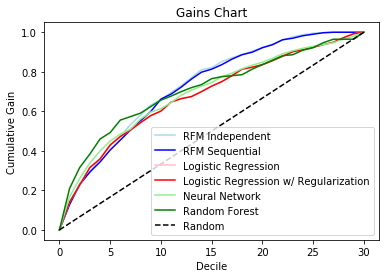

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,68.03%,68.03%,69.31%,70.82%,73.12%,72.33%


Dataset 2a


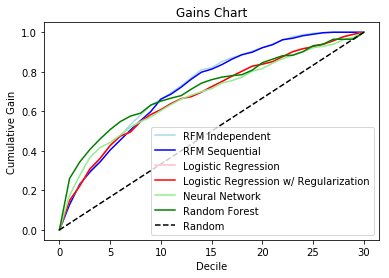

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,68.03%,68.03%,68.00%,71.08%,73.12%,72.33%


Dataset 2b


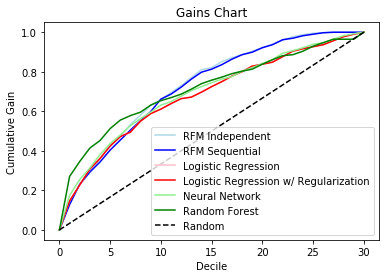

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,68.03%,68.03%,69.23%,71.32%,73.12%,72.33%


Dataset 3a


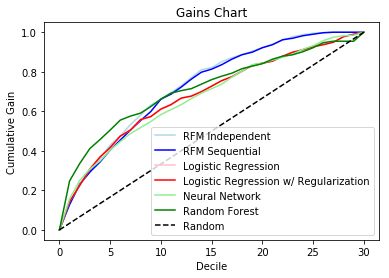

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,68.07%,68.07%,67.41%,71.30%,73.12%,72.33%


Dataset 3b


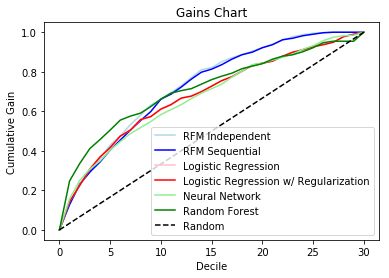

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,68.07%,68.07%,67.41%,71.30%,73.12%,72.33%


In [13]:
print("Dataset 1")
print_gains_performance(predictions1)
print("Dataset 2a")
print_gains_performance(predictions2a)
print("Dataset 2b")
print_gains_performance(predictions2b)
print("Dataset 3a")
print_gains_performance(predictions3a)
print("Dataset 3b")
print_gains_performance(predictions3b)

### c) Evaluate expected profits

In [14]:
### A function to calculate the expected profit based on a set of predictions
### by 1) removing those who have already responded, 2) identifying those whose 
### predicted probability exceeds the threshold rate, 3) halving the predicted
### response rate, 4) calculating expected profit, and 5) subtracting the mail cost
def calculate_exp_profit(predictions, field, population_size, threshold=breakeven_rate):
    # Remove people who have already responded
    second_wave_subset = predictions.loc[predictions['actual_res'] == 0]

    # Calculate the percent of people to target
    target_audience = second_wave_subset[second_wave_subset[field] > threshold]
    scaling_factor = population_size / len(second_wave_subset) # will use to scale up results

    # Calculate expected profit based on the predicted response rate (halved) times per-person profit
    # Predicted response rate is halved based on assumption in the case
    gross_profit = scaling_factor * (target_audience[field] * per_person_profit).sum()
    mail_cost = scaling_factor * len(target_audience) * per_person_mail_cost

    return [field, gross_profit - mail_cost, len(target_audience), len(second_wave_subset), 
            scaling_factor * len(target_audience), scaling_factor * len(second_wave_subset)]

### Calculate the expected profits across all the predictions
def evaluate_profits(predictions, population_size, threshold=breakeven_rate):
    exp_rfmi = calculate_exp_profit(predictions, 'p_rfmi', population_size, threshold)
    exp_rfms = calculate_exp_profit(predictions, 'p_rfms', population_size, threshold)
    exp_log = calculate_exp_profit(predictions, 'p_log', population_size, threshold)
    exp_logr = calculate_exp_profit(predictions, 'p_logr', population_size, threshold)
    exp_nn = calculate_exp_profit(predictions, 'p_nn', population_size, threshold)
    exp_rf = calculate_exp_profit(predictions, 'p_rf', population_size, threshold)

    transposed = [exp_rfmi, exp_rfms, exp_log, exp_logr, exp_nn, exp_rf]

    return pandas.DataFrame(transposed, columns=['Model', 'Expected Profit', 'Targeted People', 
                                                 'Eligible Sample', 'Targeted Population', 'Total Population'])

# Print results to console
def print_profit_performance(predictions, population_size, threshold=breakeven_rate):
    profits = evaluate_profits(predictions, population_size, threshold)
    profits = profits.style.format({'Expected Profit': '${:,.2f}',
                                        'Targeted People': '{:,.0f}',
                                        'Eligible Sample': '{:,.0f}',
                                        'Targeted Population': '{:,.0f}',
                                        'Total Population': '{:,.0f}'})
    display(profits)

Evaluate the models and determine the expected profitability for each model

In [15]:
# Run evaluation on datasets
total_population = 801821
wave_1_responders = 38487
mailing_population = total_population - wave_1_responders

print("Dataset 1")
print_profit_performance(predictions1, mailing_population, breakeven_rate)
print("Dataset 2a")
print_profit_performance(predictions2a, mailing_population, breakeven_rate)
print("Dataset 2b")
print_profit_performance(predictions2b, mailing_population, breakeven_rate)
print("Dataset 3a")
print_profit_performance(predictions3a, mailing_population, breakeven_rate)
print("Dataset 3b")
print_profit_performance(predictions3b, mailing_population, breakeven_rate)

Dataset 1


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$340,315.35","2,771","7,604","278,169","763,334"
1,p_rfms,"$339,756.41","2,963","7,604","297,443","763,334"
2,p_log,"$312,879.61","2,576","7,604","258,594","763,334"
3,p_logr,"$312,879.71","2,576","7,604","258,594","763,334"
4,p_nn,"$360,431.62","2,137","7,604","214,525","763,334"
5,p_rf,"$225,490.39","1,859","7,604","186,617","763,334"


Dataset 2a


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$340,315.35","2,771","7,604","278,169","763,334"
1,p_rfms,"$339,756.41","2,963","7,604","297,443","763,334"
2,p_log,"$312,475.39","2,590","7,604","259,999","763,334"
3,p_logr,"$312,477.06","2,590","7,604","259,999","763,334"
4,p_nn,"$362,215.34","2,185","7,604","219,343","763,334"
5,p_rf,"$209,621.81","1,762","7,604","176,880","763,334"


Dataset 2b


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$340,315.35","2,771","7,604","278,169","763,334"
1,p_rfms,"$339,756.41","2,963","7,604","297,443","763,334"
2,p_log,"$312,250.37","2,595","7,604","260,501","763,334"
3,p_logr,"$312,252.86","2,595","7,604","260,501","763,334"
4,p_nn,"$376,152.55","2,349","7,604","235,806","763,334"
5,p_rf,"$198,213.46","1,758","7,604","176,478","763,334"


Dataset 3a


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$340,315.35","2,771","7,604","278,169","763,334"
1,p_rfms,"$339,756.41","2,963","7,604","297,443","763,334"
2,p_log,"$313,768.36","2,591","7,604","260,100","763,334"
3,p_logr,"$313,770.58","2,591","7,604","260,100","763,334"
4,p_nn,"$363,862.02","2,389","7,604","239,822","763,334"
5,p_rf,"$194,715.30","1,715","7,604","172,162","763,334"


Dataset 3b


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$340,315.35","2,771","7,604","278,169","763,334"
1,p_rfms,"$339,756.41","2,963","7,604","297,443","763,334"
2,p_log,"$313,768.36","2,591","7,604","260,100","763,334"
3,p_logr,"$313,770.58","2,591","7,604","260,100","763,334"
4,p_nn,"$363,862.02","2,389","7,604","239,822","763,334"
5,p_rf,"$194,715.30","1,715","7,604","172,162","763,334"


### WARNING: THIS IS LEGACY CODE, PLEASE IGNORE

In [16]:
# Predicted response rate is half the first response rate
data['p_res2']=data['res1']/2

# Determine target customers for mailing
breakeven = 0.0235
data['second_mail'] = 1*(data['p_res2']>=breakeven)&(data['res1']==0)

# Calculate the number of customers to mail
len_second_mail = len(data[data['second_mail']==1])

# Calculate the profits from the mailing
mail_cost = 1.41
profit_per_customer = 60
profit_second_mail = (profit_per_customer*data[(data['second_mail'] == 1)]['p_res2'].mean()*len_second_mail)-(mail_cost*len_second_mail)
print(profit_second_mail)

nan
